<a href="https://colab.research.google.com/github/ggrgrtr/numbers_netwok/blob/main/CIFAR_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as q
import torchvision.datasets
import random
import numpy as np

In [2]:
random.seed(0)
np.random.seed(0)
q.manual_seed(0)
q.cuda.manual_seed(0)
q.backends.cudnn.deterministic=True

# dataset с тремя каналами
cifar_train=torchvision.datasets.CIFAR10('./',download=True,train=True)
cifar_test=torchvision.datasets.CIFAR10('./',download=True,train=False)

100%|██████████| 170M/170M [00:04<00:00, 40.5MB/s]


In [3]:

# float tensor для пикселей картинок
x_train=q.FloatTensor(cifar_train.data)
# long tensor для классов картинок
y_train=q.LongTensor(cifar_train.targets)

x_test=q.FloatTensor(cifar_test.data)
y_test=q.LongTensor(cifar_test.targets)

In [4]:
x_train.min(), x_train.max()

(tensor(0.), tensor(255.))

In [5]:
# нормируем картинки. Масштабирование: [0, 1]
# деление данных на стандартное отклонение
x_train /=255
x_test /=255

In [6]:
cifar_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

    tensor(6)       tensor(9)       tensor(9)       tensor(4)       tensor(1)       tensor(1)       tensor(2)       tensor(7)       tensor(8)       tensor(3)   

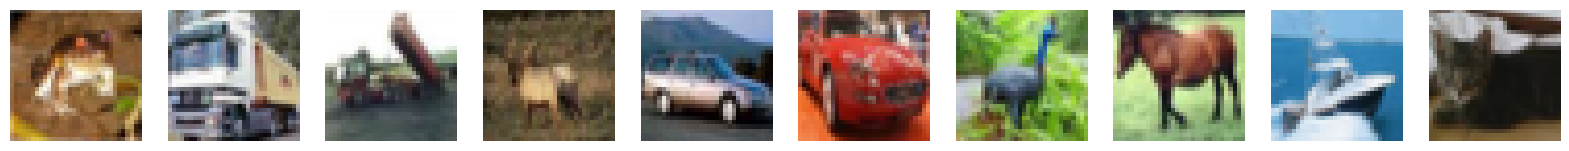

In [7]:
import matplotlib.pyplot as plt
#
plt.figure(figsize=(20,2)) # область для картинок 20*2 дюймов
for i in range(10):
  plt.subplot(1,10,i+1) # разбивает область изображения на 1 ряд и 10 колонок и место в ряду i+1
  plt.imshow(x_train[i])
  plt.axis('off') # отключает отображение осей
  print('   ',y_train[i],end='   ')


In [8]:
# pytorch нужно, чтобы первыми шли каналы изображения
x_train.shape

torch.Size([50000, 32, 32, 3])

In [9]:
# меняем местами
x_train=x_train.permute(0,3,1,2)
x_test=x_test.permute(0,3,1,2)

In [10]:
# from torch.nn.modules import conv
class LeNet(q.nn.Module):
  # задаем начальные свойства сети для изменения и последующего анализа выдаваемых ф. потерь и % верности предсказания
  def __init__(self, activation='tanh',pooling='avg',conv_size=5, use_batch_norm=False):
    super(LeNet,self).__init__()
    # для использования в forward
    self.conv_size=conv_size
    self.use_batch_norm=use_batch_norm



    if activation=='tanh':
      act_f =q.nn.Tanh()
    elif activation=='relu':
      act_f =q.nn.ReLU()
    else:
      raise NotImplementedError

    if pooling=='avg':
      pool =q.nn.AvgPool2d(kernel_size=2,stride=2)
    elif pooling=='max':
      pool =q.nn.MaxPool2d(kernel_size=2,stride=2)
    else:
      raise NotImplementedError

    # из-за отсутствующего отступа конечный тензор изображения уменьшится на 4 по оси
    if conv_size==5:
      # свертка 5*5 -> 25 весов
      self.conv1=q.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,padding=0)
    elif conv_size==3:
      # две свертки 3*3 -> 18 весов
      self.conv1_1=q.nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,padding=0)
      self.conv1_2=q.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,padding=0)
    else:
      raise NotImplementedError

    self.act1=act_f
    # 6 channels
    self.normalization1=q.nn.BatchNorm2d(num_features=6)
    self.pool1=pool


    if conv_size==5:
      self.conv2=q.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,padding=0)
    elif conv_size==3:
      self.conv2_1=q.nn.Conv2d(in_channels=6,out_channels=6,kernel_size=3,padding=0)
      self.conv2_2=q.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,padding=0)
    else:
      raise NotImplementedError


    self.act2=act_f
    self.normalization2=q.nn.BatchNorm2d(num_features=16)
    self.pool2=pool

    # в forward тензор уже будет преобразован в одномероной длиной 5*5 пикселей * 16 слоев
    self.fully_connected1=q.nn.Linear(in_features=5*5*16,out_features=120)
    self.act3=act_f

    self.fully_connected2=q.nn.Linear(120,84)
    self.act4=act_f
    self.fully_connected3=q.nn.Linear(84,10)

  def forward(self,batch):
    if self.conv_size==5:
      batch=self.conv1(batch)
    elif self.conv_size==3:
      batch=self.conv1_2(self.conv1_1(batch))
    batch=self.act1(batch)
    if self.use_batch_norm:
      batch=self.normalization1(batch)
    batch=self.pool1(batch)

    if self.conv_size==5:
      batch=self.conv2(batch)
    elif self.conv_size==3:
      batch=self.conv2_2(self.conv2_1(batch))
    batch=self.act2(batch)
    if self.use_batch_norm:
      batch=self.normalization2(batch)
    batch=self.pool2(batch)

    # tensor^4 -> tensor^2
    batch=batch.view(batch.size(0),-1)
    batch=self.fully_connected1(batch)
    batch=self.act3(batch)
    batch=self.fully_connected2(batch)
    batch=self.act4(batch)
    batch=self.fully_connected3(batch)

    return batch


In [11]:
# функция нужна для анализа НС с различными качествами
def iter_train(net,x_train,y_train,x_test,y_test):
  dev=q.device('cuda:0' if q.cuda.is_available() else 'cpu')
  net=net.to(dev)
  x_test=x_test.to(dev)
  y_test=y_test.to(dev)

  loss=q.nn.CrossEntropyLoss()
  method_opt=q.optim.Adam(net.parameters(),lr=0.001)

  loss_history=[]
  accuracy_history=[]

  batch_size=100

  for epoch in range(20):
    ord=np.random.permutation(len(x_train))

    # обучение батчами
    for ind_b in range(0,len(ord),batch_size):
      method_opt.zero_grad()
      # подбираются параметры мат. ожидания и старндартного отклонения ф. в слое
      # ставим флаг на обучение
      # параметры нормализации подстраиваются не при градиентном спуске (убывании ф. потерь), а при прямом вычеслении в forward
      net.train()

      ord_batch=ord[ind_b: ind_b+ batch_size]
      x_batch=x_train[ord_batch].to(dev)
      y_batch=y_train[ord_batch].to(dev)

      prediction=net.forward(x_batch)
      f=loss(prediction,y_batch)
      f.backward()
      method_opt.step()

    # чтобы при тестировании сети не изменяись параметры нормализации мы ставим флаг evaluation
    net.eval()
    pred_test=net.forward(x_test)
    loss_history.append(loss(pred_test,y_test).data.cpu())

    accuracy=(pred_test.argmax(dim=1)==y_test).float().mean().data.cpu()
    accuracy_history.append(accuracy)
    # print(accuracy)
  # print('-'*20)
  # print()
  del net
  return loss_history, accuracy_history




In [12]:
accuracy_variation={}
loss_variation={}

# accuracy_variation['tanh'], loss_variation['tanh'] = iter_train(LeNet(), x_train,y_train,x_test,y_test)

accuracy_variation['relu'], loss_variation['relu'] = iter_train(LeNet(activation='relu', conv_size=5), x_train,y_train,x_test,y_test)

accuracy_variation['relu+conv3'], loss_variation['relu+conv3'] = iter_train(LeNet(activation='relu', conv_size=3), x_train,y_train,x_test,y_test)

accuracy_variation['relu+conv3+maxp'], loss_variation['relu+conv3+maxp'] = iter_train(LeNet(activation='relu', conv_size=3,pooling='max'), x_train,y_train,x_test,y_test)

accuracy_variation['relu+conv3+maxp+norm'], loss_variation['relu+conv3+maxp+norm'] = iter_train(LeNet(activation='relu', conv_size=3,pooling='max',use_batch_norm=True), x_train,y_train,x_test,y_test)



tensor(0.3800)
tensor(0.4676)
tensor(0.4967)
tensor(0.5145)
tensor(0.5245)
tensor(0.5414)
tensor(0.5400)
tensor(0.5582)
tensor(0.5578)
tensor(0.5826)
tensor(0.5824)
tensor(0.5825)
tensor(0.5806)
tensor(0.5864)
tensor(0.5966)
tensor(0.5962)
tensor(0.5999)
tensor(0.6017)
tensor(0.6068)
tensor(0.6054)
--------------------

tensor(0.3012)
tensor(0.3695)
tensor(0.4369)
tensor(0.4650)
tensor(0.4841)
tensor(0.4994)
tensor(0.5149)
tensor(0.5236)
tensor(0.5335)
tensor(0.5446)
tensor(0.5472)
tensor(0.5591)
tensor(0.5652)
tensor(0.5664)
tensor(0.5734)
tensor(0.5682)
tensor(0.5760)
tensor(0.5679)
tensor(0.5764)
tensor(0.5847)
--------------------

tensor(0.3684)
tensor(0.4399)
tensor(0.4766)
tensor(0.5182)
tensor(0.5318)
tensor(0.5499)
tensor(0.5727)
tensor(0.5769)
tensor(0.5826)
tensor(0.5894)
tensor(0.6008)
tensor(0.6067)
tensor(0.6095)
tensor(0.6091)
tensor(0.6147)
tensor(0.6178)
tensor(0.6254)
tensor(0.6259)
tensor(0.6177)
tensor(0.6307)
--------------------

tensor(0.4695)
tensor(0.5687)
tens

In [13]:
# accuracy_variation['relu+conv3+maxp'], loss_variation['relu+conv3+maxp'] = iter_train(LeNet(activation='relu', conv_size=3,pooling='max'), x_train,y_train,x_test,y_test)


In [14]:
# accuracy_variation['relu+conv3'], loss_variation['relu+conv3'] = iter_train(LeNet(activation='relu', conv_size=3), x_train,y_train,x_test,y_test)

Text(0.5, 1.0, 'Validation Accuracy')

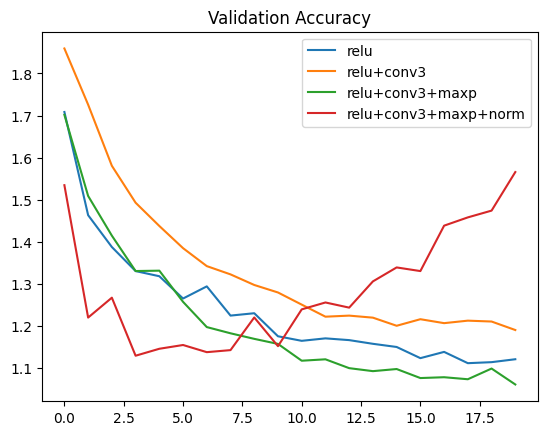

In [15]:
for experiment_id in accuracy_variation.keys():
    plt.plot(accuracy_variation[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy')

Text(0.5, 1.0, 'Validation Loss')

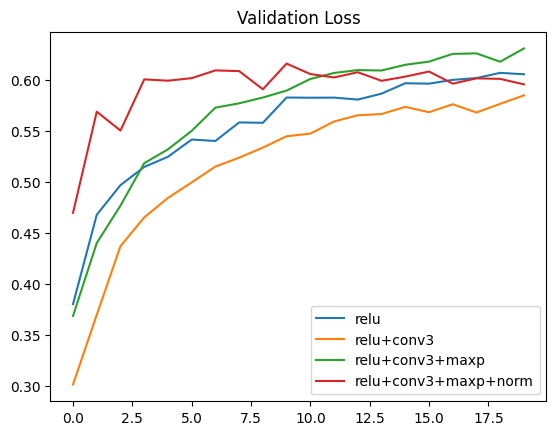

In [16]:
for experiment_id in loss_variation.keys():
    plt.plot(loss_variation[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss')

In [16]:
class CIFAR_net(q.nn.Moddule):
  def __init__(self):
    super(CIFAR_net,self).__init__()
    self.batch_normalization_0=q.nn.BatchNorm2d(3) # 3 channels initially: RGB

    # channels 3 -> 16
    # отступ 1, чтобы при свертке 3*3 не изменился размер тензора
    self.convolution1=q.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1)

    # заменяет все отрицательные значения на ноль
    self.activ1=q.nn.ReLU()
    self.batch_normalization_channel_16=q.nn.BatchNorm2d(16)

    #  уменьшвет количество параметров и вычислительную сложность 32*23 -> 16*16
    self.pooling1=q.nn.MaxPool2d(2,2)

    self.convolution2=
    self.activ2=q.nn.ReLU()
    self.